In [ ]:
import os
import logging

logging.basicConfig(level=logging.ERROR)

import pandas as pd
from tqdm import tqdm

from src.util import seed_everything, update_avg
from src.config import SEED, INTERIM_DATA_DIR, OPENAI_API_KEY
from src.metrics import calculate_all
from src.data.dataset import create_loaders
from src.models.openai_model import FewShotModel

In [2]:
if not INTERIM_DATA_DIR.exists():
    os.chdir("..")

In [3]:
seed_everything(SEED)

In [4]:
BATCH_SIZE = 32
NUM_BATCHES = 3

In [5]:
train_loader, val_loader, test_loader = create_loaders(
    pd.read_csv(INTERIM_DATA_DIR / "swapped.csv"), batch_size=BATCH_SIZE
)

In [16]:
train_samples = [s[:6] for s in next(iter(train_loader))]

In [17]:
model = FewShotModel(OPENAI_API_KEY, *train_samples)

In [18]:
all_predictions = []
all_sources = []
avg_non_tox = 0
avg_bert = 0
avg_bleu = 0
for i, batch in (pbar := tqdm(enumerate(test_loader), total=NUM_BATCHES)):
    inputs, target = batch
    all_sources.extend(inputs)
    test_pred = model.predict(inputs)
    all_predictions.extend(test_pred)
    non_tox, bert, bleu = calculate_all(
        inputs, test_pred[:BATCH_SIZE], target, BATCH_SIZE
    )
    avg_non_tox = update_avg(avg_non_tox, non_tox, i)
    avg_bert = update_avg(avg_bert, bert, i)
    avg_bleu = update_avg(avg_bleu, bleu, i)
    pbar.set_description(f"{avg_non_tox=:.3f} {avg_bert=:.3f} {avg_bleu=:.3f}")
    if i + 1 >= NUM_BATCHES:
        break

avg_non_tox=0.688 avg_bert=0.532 avg_bleu=0.152:  67%|██████▋   | 2/3 [00:37<00:18, 18.72s/it]


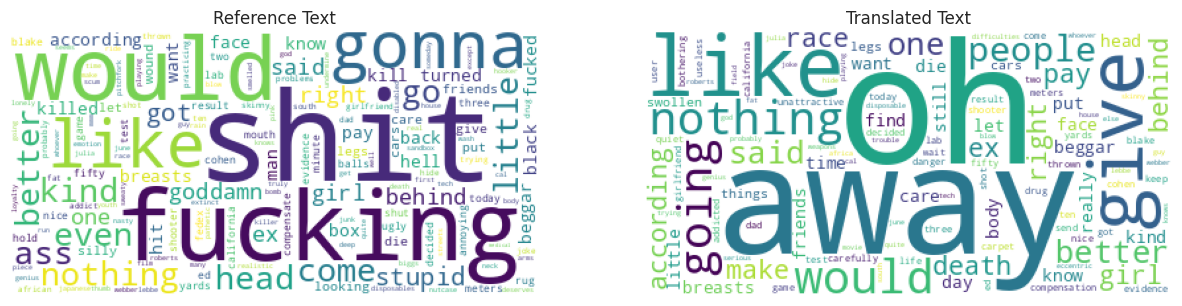

In [19]:
import matplotlib.pyplot as plt
from src.visualization.make_wordcloud import make_wordcloud

_, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(make_wordcloud(pd.Series(all_sources)))
axes[0].axis("off")
axes[0].set_title("Reference Text")

axes[1].imshow(make_wordcloud(pd.Series(all_predictions)))
axes[1].axis("off")
axes[1].set_title("Translated Text")
plt.show()